In [229]:
%matplotlib inline
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import umap
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
sns.set(style="darkgrid")
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from ipywidgets import interact, IntSlider, fixed, FloatSlider
from sklearn.metrics import silhouette_score

In [127]:
data_set = pd.read_csv('economic_freedom.csv', encoding="ISO-8859-1")
data_set = data_set.drop(["Country", "WEBNAME"], axis=1)

In [128]:
data_set.columns = ['id', 'name', 'region', 'world_rank',
       'region_rank', 'score', 'property_rights', 'judical_effectiveness',
       'gov_integrity', 'tax_burden', 'gov_spending', 'fiscal_health',
       'business_freedom', 'labor_freedom', 'monetary_freedom',
       'trade_freedom', 'investment_freedom ', 'financial_freedom',
       'tariff_rate', 'income_tax_rate', 'corp_tax_rate',
       'tax_burden', 'gov_expenditure',
       'population', 'gdp', 'gdp_growth_rate',
       'five_year_gdp_growth_rate', 'gdp_per_capita',
       'unemployment', 'inflation', 'fdi_inflow',
       'public_debt']

In [129]:
data_set.gdp = data_set.gdp.str[1:]
data_set.fdi_inflow = data_set.fdi_inflow.str[1:]
data_set.gdp_per_capita = data_set.gdp_per_capita.str[1:]
data_set.gdp = data_set.gdp.str.replace(',', '')
data_set.fdi_inflow = data_set.fdi_inflow.str.replace(',', '')
data_set.gdp_per_capita = data_set.gdp_per_capita.str.replace(',', '')

In [130]:
data_set

,id,name,region,world_rank,region_rank,score,property_rights,judical_effectiveness,gov_integrity,tax_burden,...,gov_expenditure,population,gdp,gdp_growth_rate,five_year_gdp_growth_rate,gdp_per_capita,unemployment,inflation,fdi_inflow,public_debt
0,1,Afghanistan,Asia-Pacific,152.0,39.0,51.5,19.6,29.6,25.2,91.7,...,25.6,35.5,69.6,2.5,2.9,1958,8.8,5.0,3.9,7.3
1,2,Albania,Europe,52.0,27.0,66.5,54.8,30.6,40.4,86.3,...,29.5,2.9,36.0,3.9,2.5,12507,13.9,2.0,119.1,71.2
2,3,Algeria,Middle East and North Africa,171.0,14.0,46.2,31.6,36.2,28.9,76.4,...,41.4,41.5,632.9,2.0,3.1,15237,10.0,5.6,203.0,25.8
3,4,Angola,Sub-Saharan Africa,156.0,33.0,50.6,35.9,26.6,20.5,83.9,...,25.3,28.2,190.3,0.7,2.9,6753,8.2,31.7,2254.5,65.3
4,5,Argentina,Americas,148.0,26.0,52.2,47.8,44.5,33.5,69.3,...,41.0,44.1,920.2,2.9,0.7,20876,8.7,25.7,1857.0,52.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,179,Venezuela,Americas,179.0,32.0,25.9,7.6,13.1,7.9,74.7,...,37.4,31.4,380.7,-14.0,-7.8,12114,7.7,1087.5,68.0,34.9
182,180,Vietnam,Asia-Pacific,128.0,30.0,55.3,49.8,40.3,34.0,79.7,...,29.4,93.6,647.4,6.8,6.2,6913,2.1,3.5,4100.0,58.2
183,181,Yemen,Middle East and North Africa,NaN,NaN,NaN,19.6,22.2,20.3,NaN,...,NaN,30.0,38.6,-13.8,-16.1,1287,14.0,4.9,269.9,141.0
184,182,Zambia,Sub-Saharan Africa,138.0,27.0,53.6,45.0,35.6,32.3,72.3,...,25.8,17.2,68.9,3.6,4.0,3996,7.8,6.6,091.2,62.2


In [120]:
sns.pairplot(data_set, hue='region', vars=['region', 'business_freedom', 'labor_freedom', 'monetary_freedom', 
                                           'trade_freedom', 'investment_freedom ', 'financial_freedom'])

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

Нормирование данных по их математическому ожиданию и стандартному отклонению (z-score):

In [170]:
def make_dict(series):
    keys = list(series.value_counts().keys())
    return keys, {keys[i]:i for i in range(len(keys))}

def draw_projections(data, columns):
    fig = plt.figure(figsize=(10, 10))
    proj = '3d' if data.shape[1] == 3 else None
    a = math.ceil(math.sqrt(len(columns)))
    
    for i in range(len(columns)):
        keys, d = make_dict(data_set[columns[i]])
        colors = [sns.color_palette("husl", len(d))[x] for x in data_set[columns[i]].map(d)]
        subplot = fig.add_subplot(int(f'{a}{a}{i + 1}'), projection=proj)
        
        if data.shape[1] == 1:
            subplot.scatter(data[:, 0], c=colors)
        elif data.shape[1] == 2:
            subplot.scatter(data[:, 0], data[:, 1], c=colors)
        elif data.shape[1] == 3:
            subplot.scatter(data[:, 0], data[:, 1], data[:, 2], c=colors) 
            
        subplot.title.set_text(f"UMAP projection by {columns[i]}")
            
        patches = [mpatches.Patch(color=sns.color_palette("hls", len(d))[i], label=keys[i]) for i in range(len(keys))]

        subplot.legend(handles=patches, ncol=10, loc="lower center")

In [188]:
def draw_umap(data, columns, n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', draw=True):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric,
        random_state=42
    )
    
    result = fit.fit_transform(data)
    
    if draw:
        draw_projections(result, columns)
        plt.title(f"neighbors = {n_neighbors}, min_dist={min_dist}, components={n_components}, metric={metric}")
    
    return result

Результаты проекции в двумерное пространство с помощью UMAP:

<ipython-input-134-8f08c2d7336c>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(10, 10))


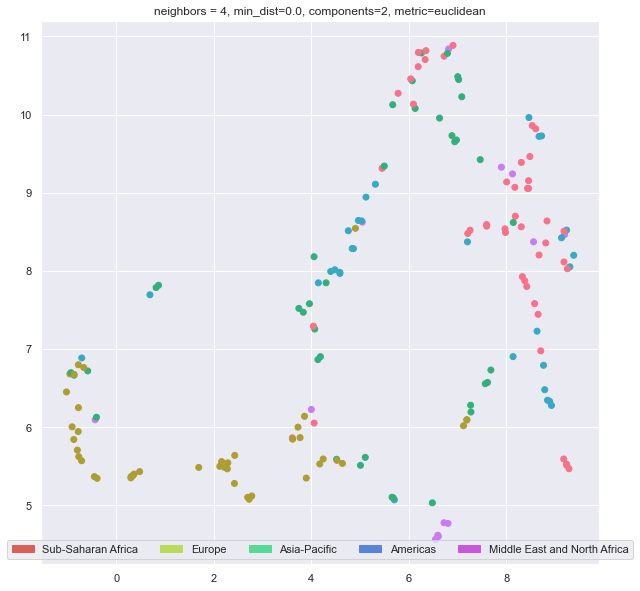

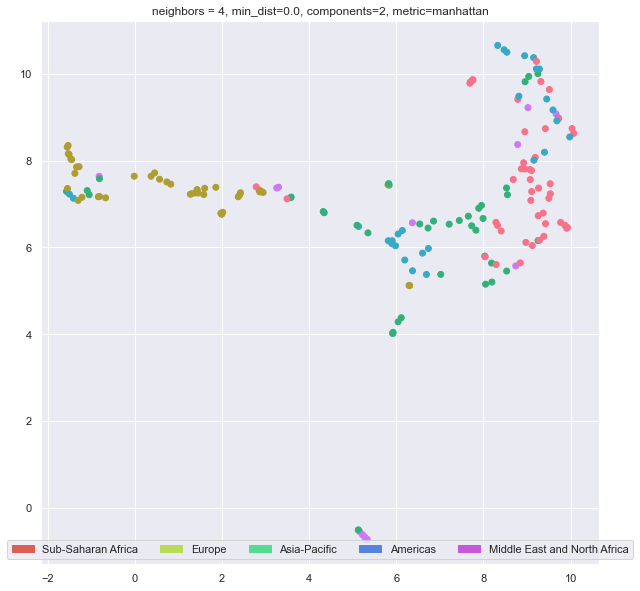

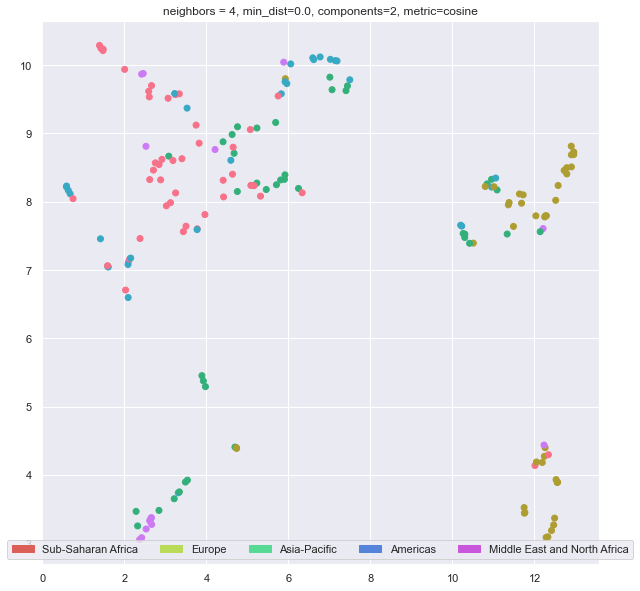

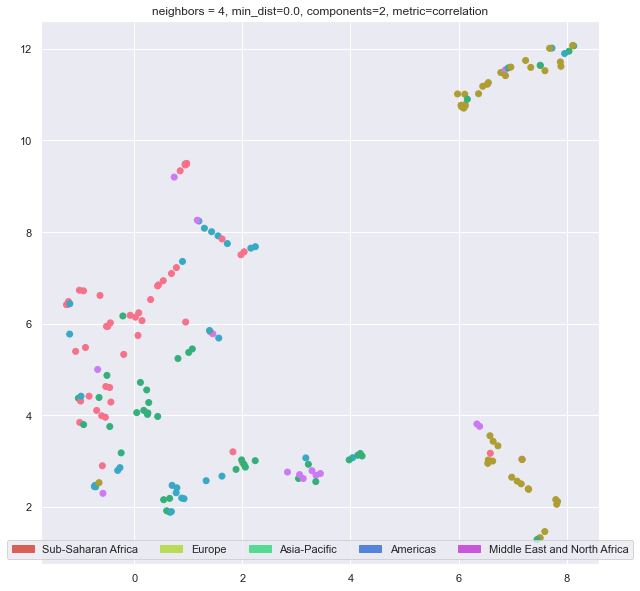

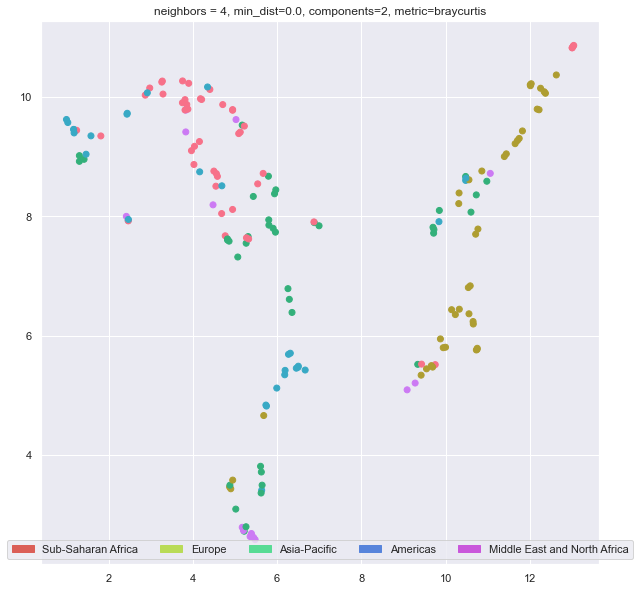

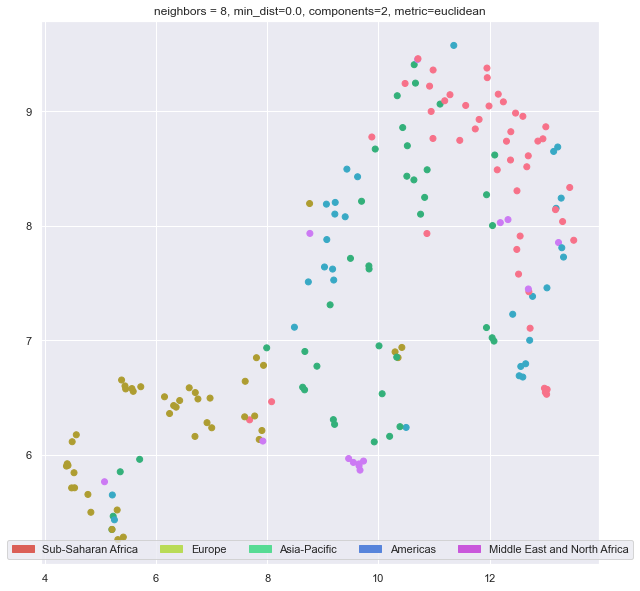

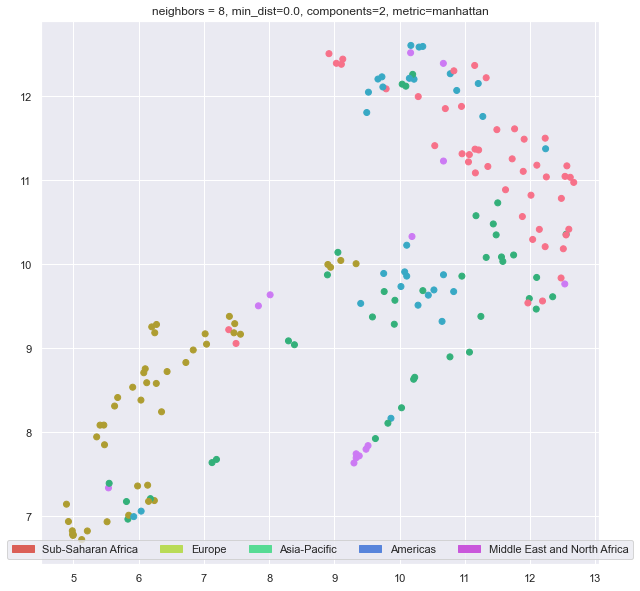

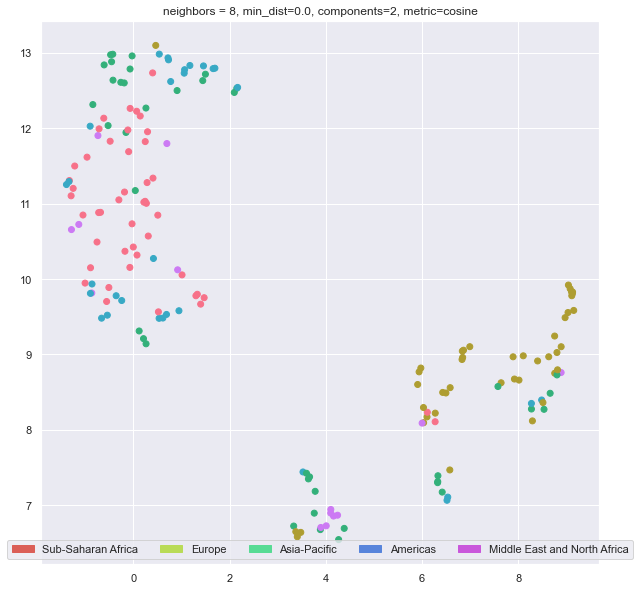

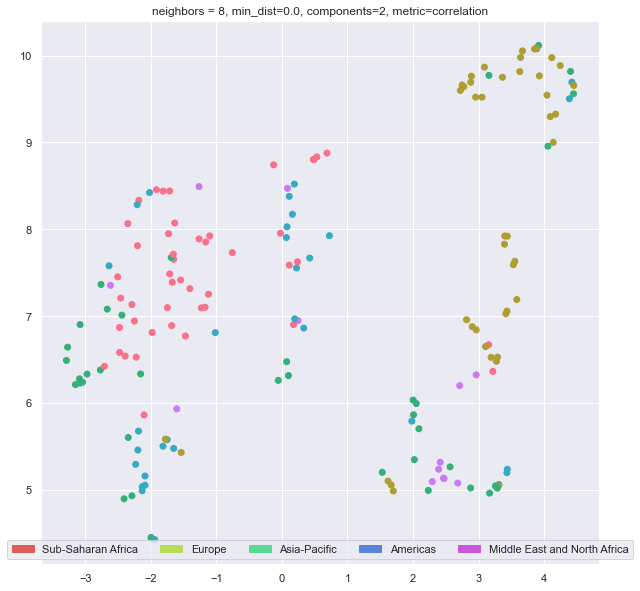

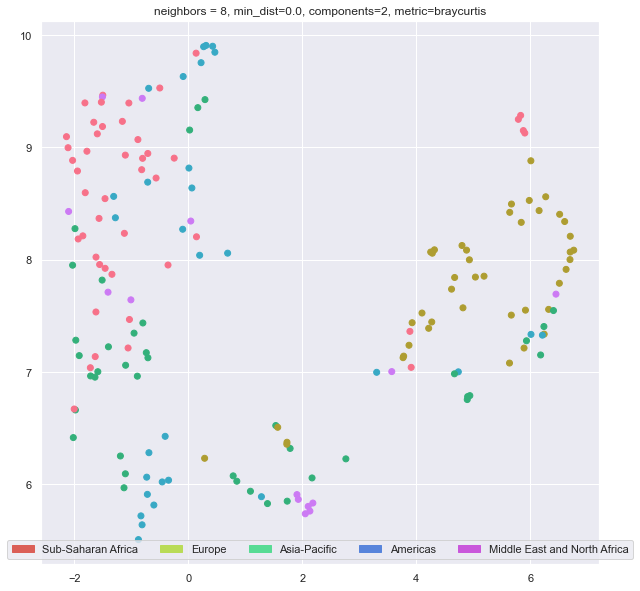

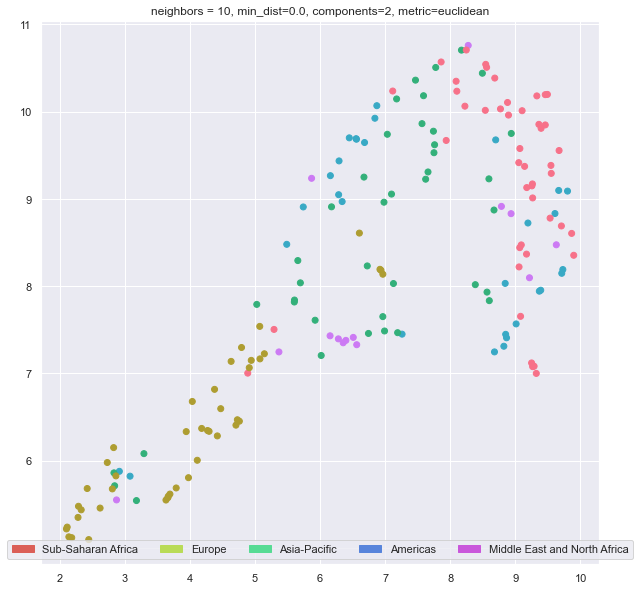

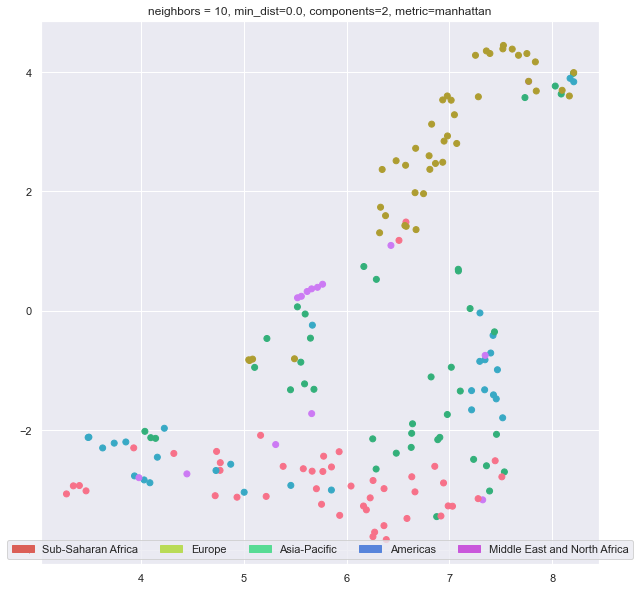

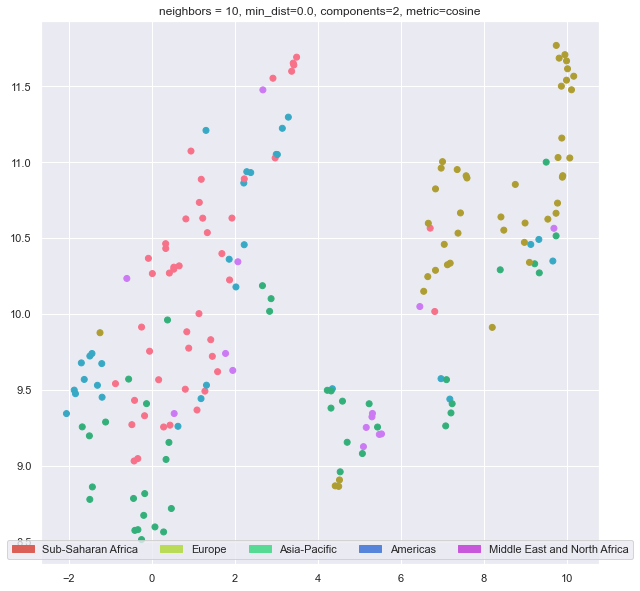

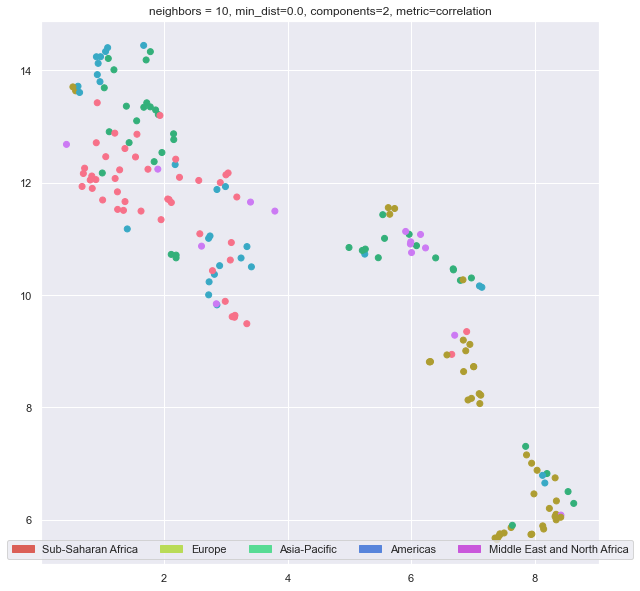

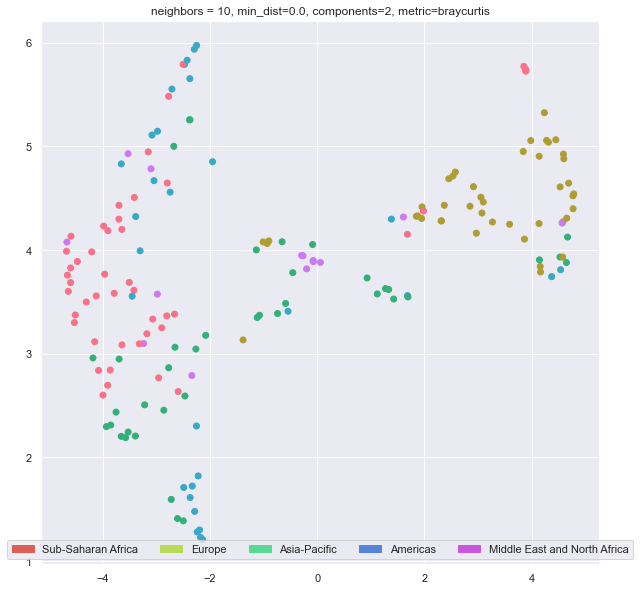

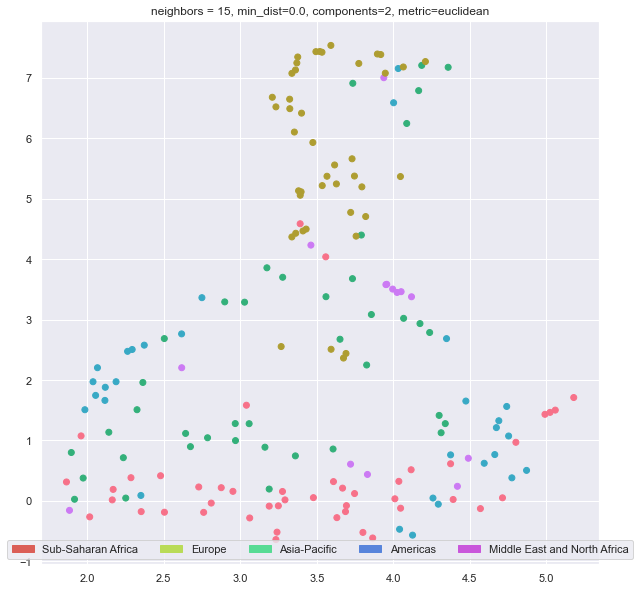

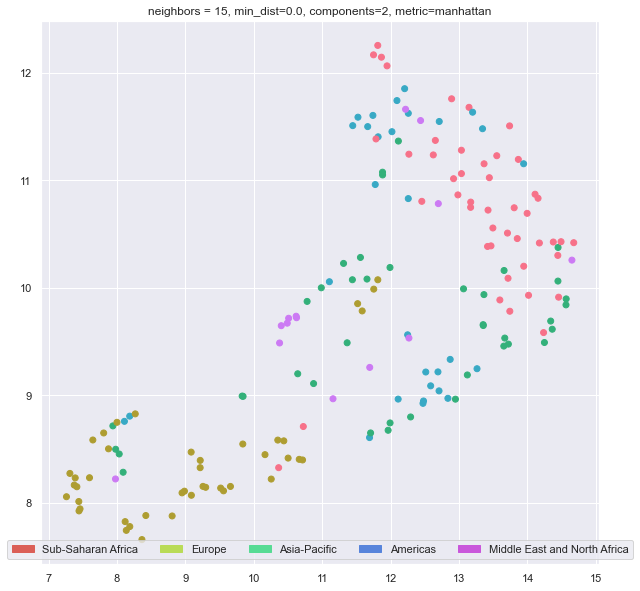

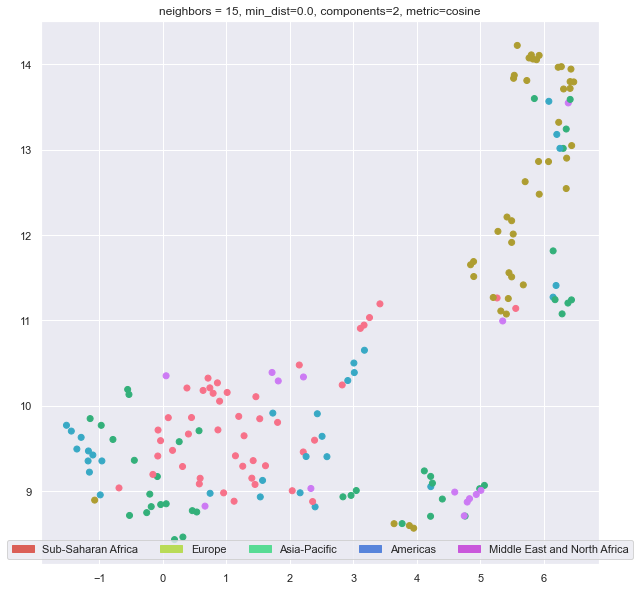

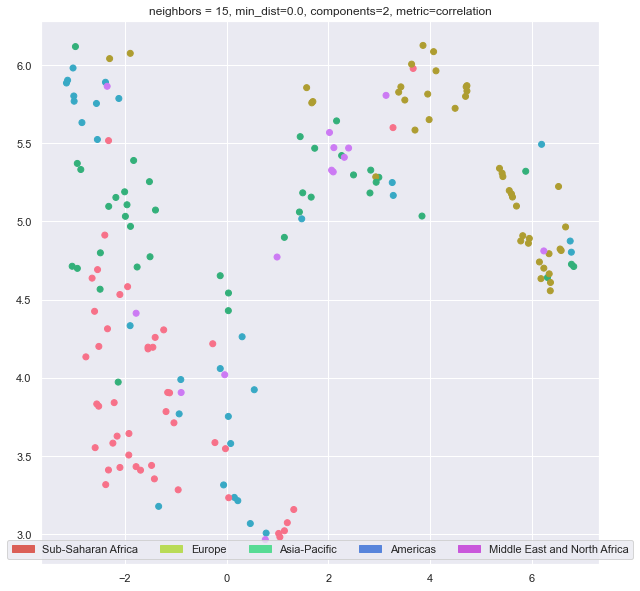

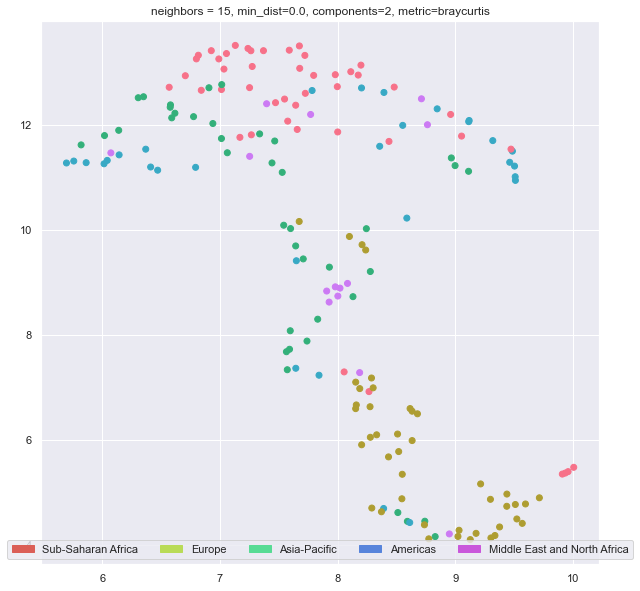

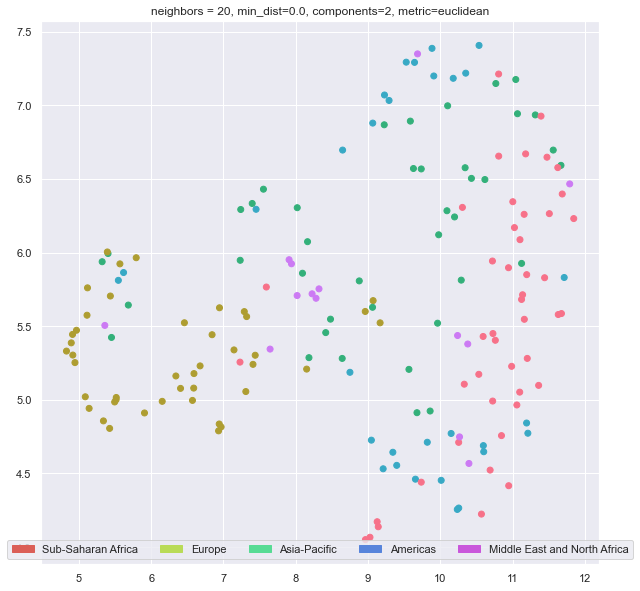

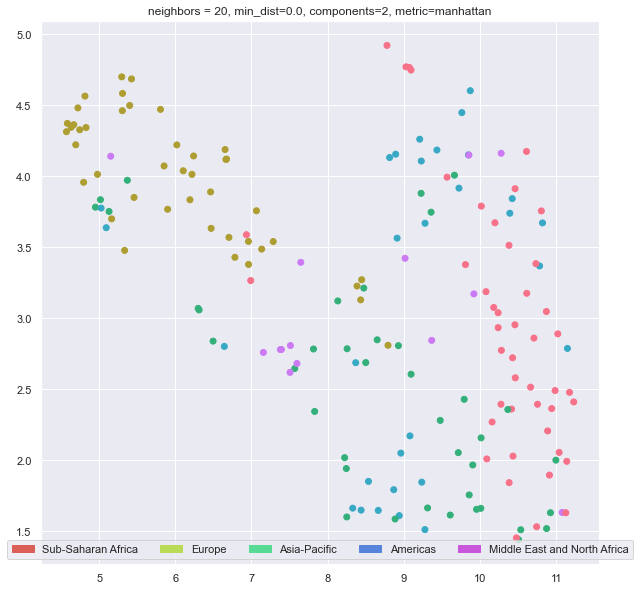

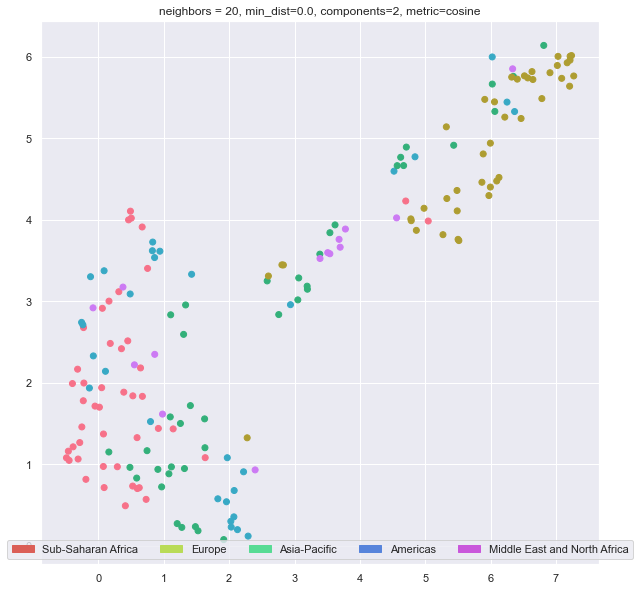

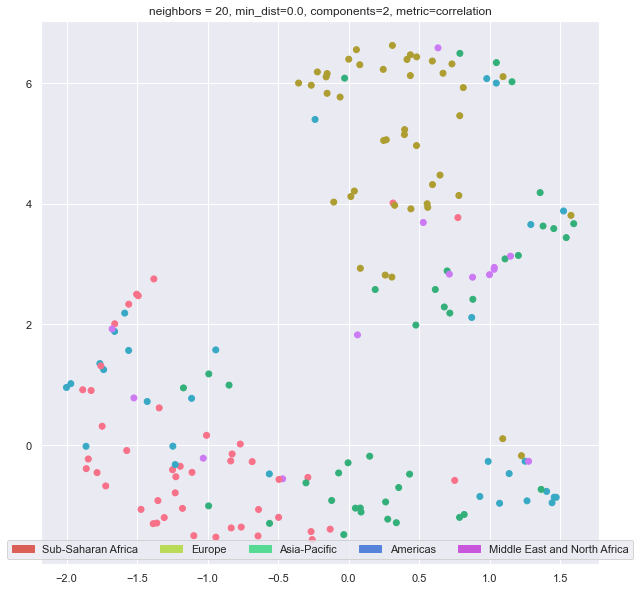

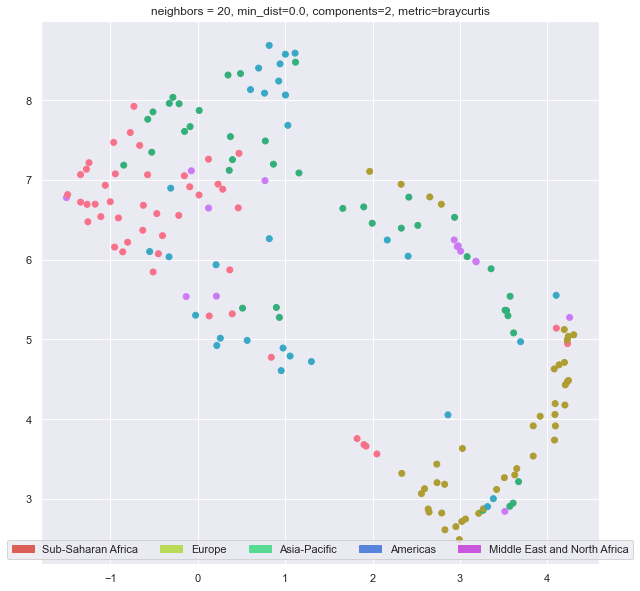

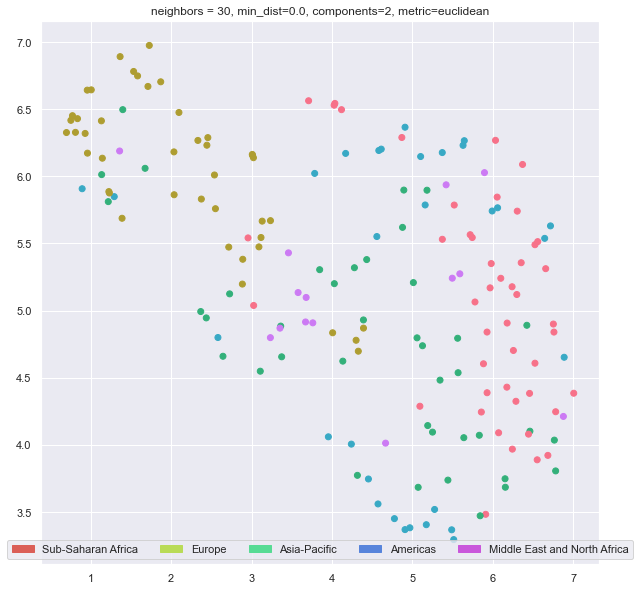

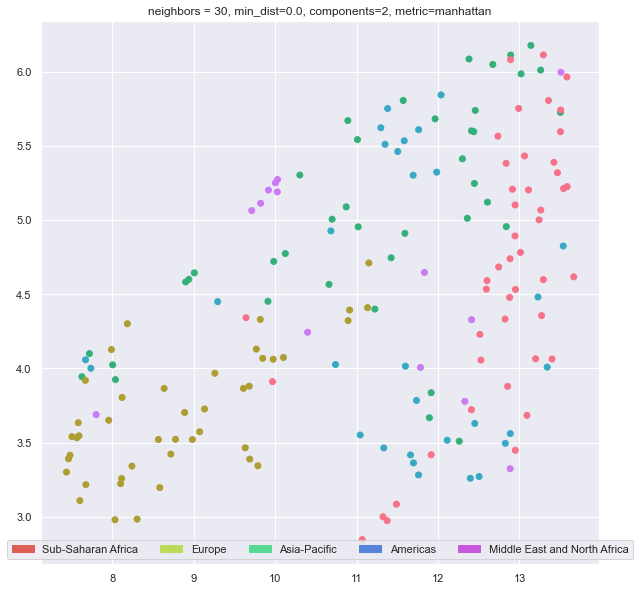

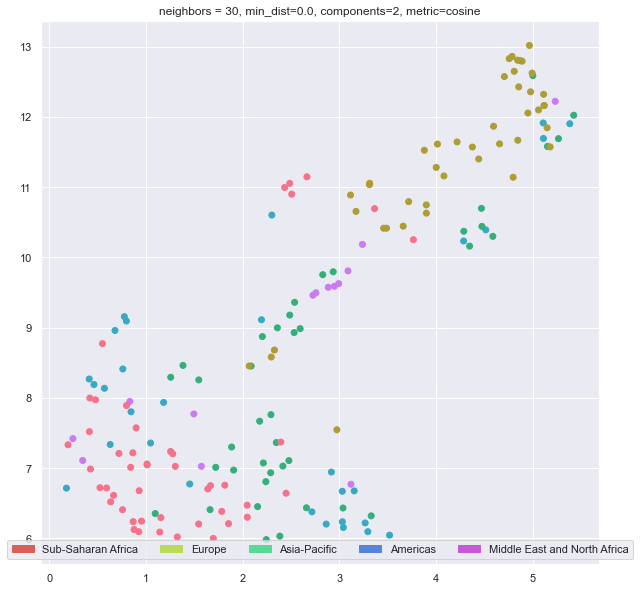

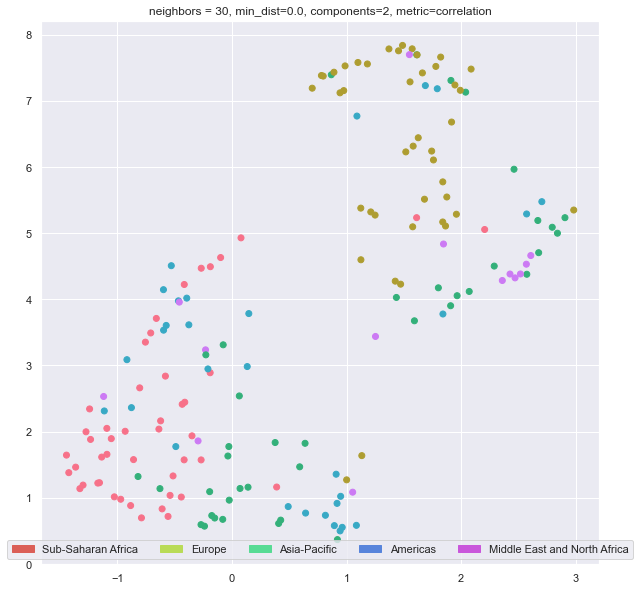

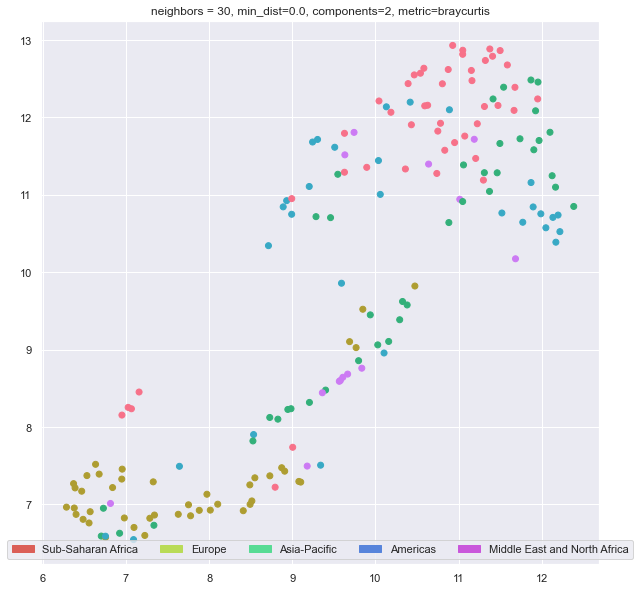

In [141]:
data_set = data_set.dropna()
scaled_data_values = StandardScaler().fit_transform(data_set[['property_rights', 'judical_effectiveness',
       'gov_integrity', 'tax_burden', 'gov_spending', 'fiscal_health',
       'business_freedom', 'labor_freedom', 'monetary_freedom',
       'trade_freedom', 'investment_freedom ', 'financial_freedom',
       'tariff_rate', 'income_tax_rate', 'corp_tax_rate',
       'tax_burden', 'gov_expenditure',
       'population', 'gdp', 'gdp_growth_rate',
       'five_year_gdp_growth_rate', 'gdp_per_capita',
       'unemployment', 'inflation', 'fdi_inflow',
       'public_debt']].values)

for i in [4, 8, 10, 15, 20, 30]:
    draw_umap(scaled_data_values, ["region"], n_neighbors=i, min_dist=0.0, n_components=2, metric='euclidean')
    draw_umap(scaled_data_values, ["region"], n_neighbors=i, min_dist=0.0, n_components=2, metric='manhattan')
    draw_umap(scaled_data_values, ["region"], n_neighbors=i, min_dist=0.0, n_components=2, metric='cosine')
    draw_umap(scaled_data_values, ["region"], n_neighbors=i, min_dist=0.0, n_components=2, metric='correlation')
    draw_umap(scaled_data_values, ["region"], n_neighbors=i, min_dist=0.0, n_components=2, metric='braycurtis')

In [142]:
data_values = data_set[['property_rights', 'judical_effectiveness',
       'gov_integrity', 'tax_burden', 'gov_spending', 'fiscal_health',
       'business_freedom', 'labor_freedom', 'monetary_freedom',
       'trade_freedom', 'investment_freedom ', 'financial_freedom',
       'tariff_rate', 'income_tax_rate', 'corp_tax_rate',
       'tax_burden', 'gov_expenditure',
       'population', 'gdp', 'gdp_growth_rate',
       'five_year_gdp_growth_rate', 'gdp_per_capita',
       'unemployment', 'inflation', 'fdi_inflow',
       'public_debt']]b
data_values

,property_rights,judical_effectiveness,gov_integrity,tax_burden,tax_burden,gov_spending,fiscal_health,business_freedom,labor_freedom,monetary_freedom,...,gov_expenditure,population,gdp,gdp_growth_rate,five_year_gdp_growth_rate,gdp_per_capita,unemployment,inflation,fdi_inflow,public_debt
0,19.6,29.6,25.2,91.7,5.0,80.3,99.3,49.2,60.4,76.7,...,25.6,35.5,69.6,2.5,2.9,1958,8.8,5.0,3.9,7.3
1,54.8,30.6,40.4,86.3,24.9,73.9,80.6,69.3,52.7,81.5,...,29.5,2.9,36.0,3.9,2.5,12507,13.9,2.0,119.1,71.2
2,31.6,36.2,28.9,76.4,24.5,48.7,18.7,61.6,49.9,74.9,...,41.4,41.5,632.9,2.0,3.1,15237,10.0,5.6,203.0,25.8
3,35.9,26.6,20.5,83.9,20.6,80.7,58.2,55.7,58.8,55.4,...,25.3,28.2,190.3,0.7,2.9,6753,8.2,31.7,2254.5,65.3
4,47.8,44.5,33.5,69.3,30.8,49.5,33.0,56.4,46.9,60.2,...,41.0,44.1,920.2,2.9,0.7,20876,8.7,25.7,1857.0,52.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,65.9,36.4,51.9,97.3,16.3,54.1,15.3,52.4,58.8,75.0,...,39.1,0.3,0.8,4.2,2.4,2739,5.2,3.1,4.7,48.4
181,7.6,13.1,7.9,74.7,14.9,58.1,17.6,33.9,28.0,0.0,...,37.4,31.4,380.7,-14.0,-7.8,12114,7.7,1087.5,68.0,34.9
182,49.8,40.3,34.0,79.7,18.0,74.1,40.7,63.5,62.8,68.9,...,29.4,93.6,647.4,6.8,6.2,6913,2.1,3.5,4100.0,58.2
184,45.0,35.6,32.3,72.3,17.9,80.1,12.3,71.1,46.0,70.3,...,25.8,17.2,68.9,3.6,4.0,3996,7.8,6.6,091.2,62.2


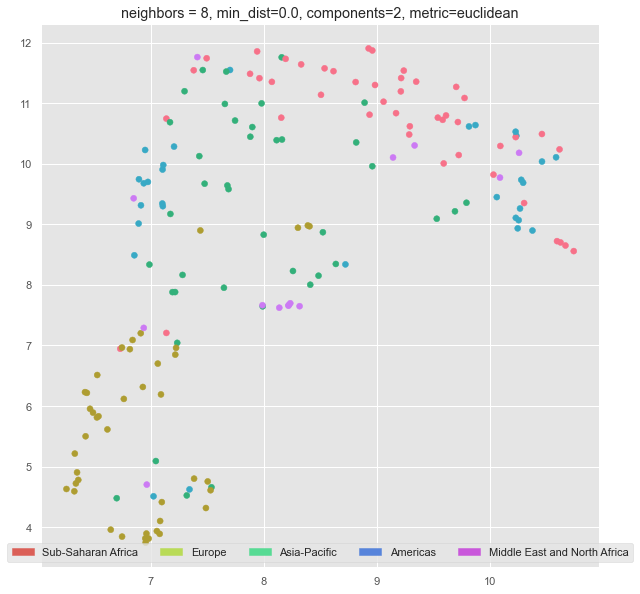

In [204]:
    projection = draw_umap(scaled_data_values, ["region"], n_neighbors=8, 
                       min_dist=0.0, n_components=2, metric='euclidean')

In [235]:
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 10)

In [236]:
def draw_kmeans(n=2):
    kmeans = KMeans(n_clusters=n).fit(projection)

    fig, ax = plt.subplots(1,1)
    ax.scatter(projection[:,0], projection[:,1], c=kmeans.labels_)
    
    ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
                  marker='o', c="white", alpha=1, s=200)
    
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')

    for i, c in enumerate(kmeans.cluster_centers_):
        ax.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)
    plt.show()
    
interact(draw_kmeans, n=IntSlider(min=2,max=12,step=1,value=2));

interactive(children=(IntSlider(value=2, description='n', max=12, min=2), Output()), _dom_classes=('widget-int…

In [223]:
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16, 8)

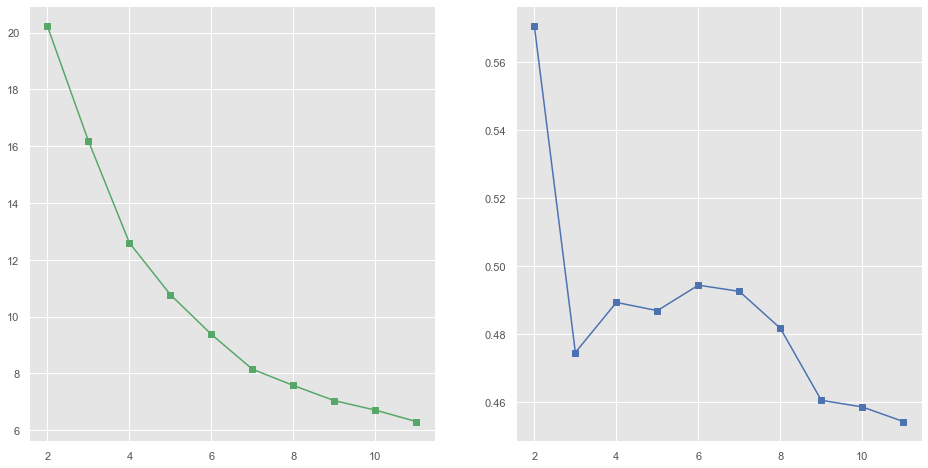

In [228]:
elbow = []
silhouette = []

for k in range(2, 12):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(projection)
    elbow.append(np.sqrt(kmeans.inertia_))
    silhouette.append(silhouette_score(projection, kmeans.labels_))
    
fig, ax = plt.subplots(1, 2)
    
ax[0].plot(range(2,12), elbow, marker='s', c='g')
ax[1].plot(range(2,12), silhouette, marker='s', c='b')

plt.show()

In [260]:
def draw_dbscan(eps=1, min_pts=5):
    dbscan = DBSCAN(eps=eps, min_samples=min_pts).fit(projection)

    fig, ax = plt.subplots(1,1)
    ax.scatter(projection[:,0], projection[:,1], c=dbscan.labels_)
    
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')

    plt.show()
    
    clusters = set(dbscan.labels_)
    
interact(draw_dbscan, eps=FloatSlider(min=0.1, max=3, step=0.05, value=1), min_pts=IntSlider(min=2, max=15, step=1, value=5));

interactive(children=(FloatSlider(value=1.0, description='eps', max=3.0, min=0.1, step=0.05), IntSlider(value=…

In [256]:
dbscan = DBSCAN(eps=0.65, min_samples=7).fit(projection)
labels = list(set(dbscan.labels_))
markers = ['.', 'o', '1', '2', '3', '4', 'p']
d = {labels[i]:markers[i] for i in range(len(labels))}
list(map(lambda l: d[l], dbscan.labels_))

['.',
 'o',
 '.',
 '.',
 '.',
 'o',
 'o',
 'o',
 '2',
 '1',
 '1',
 '.',
 '.',
 '2',
 'o',
 '.',
 '.',
 '.',
 '.',
 'o',
 'o',
 '.',
 '1',
 'o',
 '.',
 '.',
 '.',
 '.',
 '.',
 'o',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 'o',
 'o',
 'o',
 'o',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 'o',
 '.',
 '.',
 '.',
 'o',
 'o',
 '.',
 '.',
 'o',
 'o',
 '.',
 'o',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 'o',
 'o',
 'o',
 '.',
 '.',
 '.',
 'o',
 'o',
 'o',
 '.',
 'o',
 'o',
 '1',
 '.',
 'o',
 '1',
 '1',
 '.',
 'o',
 '.',
 '.',
 '.',
 'o',
 'o',
 'o',
 'o',
 '.',
 '.',
 '1',
 '1',
 '.',
 'o',
 '.',
 'o',
 '.',
 '.',
 '.',
 'o',
 '.',
 '.',
 '.',
 '.',
 'o',
 'o',
 '.',
 '.',
 '.',
 'o',
 '1',
 '.',
 '.',
 '.',
 '.',
 '.',
 '.',
 'o',
 'o',
 '1',
 'o',
 '2',
 '.',
 '.',
 '.',
 '.',
 '.',
 '1',
 '.',
 'o',
 '.',
 '1',
 'o',
 'o',
 '.',
 '.',
 'o',
 '.',
 '.',
 '.',
 'o',
 'o',
 '3',
 '.',
 '.',
 '.',
 '1',
 '.',
 '2',
 '.',
 '.',
 'o',
 '.',
 '.',
 '2',
 '1',
 'o',
 'o',
 '.'